In [1]:
from util_fdp import *
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator
from matplotlib.ticker import FuncFormatter

Z_SCORES = {
    'log'   : 6.753,
    'cons'  : 6.74735,
     1/3    : 6.339,
     1/2    : 5.851,
     2/3    : 4.993}

ABC_TABLE = {
    (0.25, 1):(0.51, 100, 20), 
    (0.25, 5):(0.51, 100, 20), 
    (0.25, 'log'):(0.51, 100, 20), 
    (0.9, 1): (0.51, 100, 20),
    (0.9, 5): (0.568, 0, 1),
    (0.9, 'log'): (0.782, 25, 2),
}
DEFAULT_ABC = (0.51, 100, 20)
def get_abc(E_typ: str, E_cons, r: float,
            default=DEFAULT_ABC, table=ABC_TABLE):
    """
    根据 (E_typ, E_cons, r) 返回 (a, b, c)。
    - E_typ ∈ {"cons", "log"}
    - E_cons ∈ {1, 5}  （当 E_typ == "cons" 时才使用）
    - r ∈ {0.25, 0.9}
    未匹配到时返回 default。
    """
    if gene_process == 'hete':
        key = (r, "log") if E_typ == "log" else (r, E_cons)
        return table.get(key, default)
    else:
        return (0.51, 100, 20)

# ── 必要导入 ───────────────────────────────────────────────────
from util_fdp import run_federated_trajectory
import numpy as np, matplotlib.pyplot as plt, matplotlib as mpl
np.random.seed(2020)
# ── 全局设置（一次写好，到处复用）────────────────────────────
mpl.rcParams.update({
    'font.size': 13, 'axes.titlesize': 16, 'axes.labelsize': 14,
    'legend.fontsize': 12, 'lines.linewidth': 2.4,
})
COLORS = {
    'global': '#0072B2',   # 深蓝
    'c0'    : '#009E73',   # 绿
    'c9'    : '#7E79D2',   # 橙
    'ci'    : '#D55E00',   # 淡紫
}

In [2]:
# ────────────── 曲线抽取 ──────────────
def get_curves(E_typ, E_cons, N, r,
               *, seed=2020, n_clients=10,
               gene_process='hete', taus=0.5, rs=None):
    """返回：xs_g, gavg, lo, up, true_q, xs_c0, c0, xs_c9, c9"""
    if rs is None:
        rs = [r] * n_clients

    a, b, c = get_abc(E_typ, E_cons, r)
    true_q, traj = run_federated_trajectory(
        dist_type='normal', taus=taus,
        client_rs=rs, n_clients=n_clients, T=N,
        E_typ=E_typ, E_cons=E_cons, gene_process=gene_process,
        mode='federated', T_mode='samples',
        base_seed=seed, a=a, b=b, c=c)

    # Global
    g_hist, v_hist = traj['global']['global_q_avg'], traj['global']['global_variance']
    xs_g = np.array(sorted(g_hist))
    gavg = np.array([g_hist[k] for k in xs_g])
    gvar = np.array([v_hist[k] for k in xs_g])
    z    = Z_SCORES.get(E_typ, Z_SCORES['cons'])
    lo, up = gavg - z*np.sqrt(gvar), gavg + z*np.sqrt(gvar)

    # Clients 0 & 9
    c0_hist, c9_hist = traj['local']['client_0'], traj['local']['client_5']
    xs_c0, xs_c9 = map(lambda h: np.array(sorted(h)), (c0_hist, c9_hist))
    c0  = np.array([c0_hist[k] for k in xs_c0])
    c9  = np.array([c9_hist[k] for k in xs_c9])

    return xs_g, gavg, lo, up, true_q, xs_c0, c0, xs_c9, c9

In [3]:
def _safe_plot(ax, xs, ys, *args, **kwargs):
    """避免 NaN 或近零水平线"""
    xs, ys = np.asarray(xs), np.asarray(ys)
    if np.all(np.isnan(ys)) or np.allclose(ys, 0, atol=1e-12):
        return
    ax.plot(xs[~np.isnan(ys)], ys[~np.isnan(ys)], *args, **kwargs)
    
def plot_single(ax, curves, title, *, scale=100, y_lims=None, skip_frac=0.05):
    xs, gavg, lo, up, true_q, xs_c0, c0, xs_c9, c9 = curves

    # -------- 统一裁掉前 5 % ----------
    if skip_frac:
        x_cut = xs.max() * skip_frac          # 阶段性阈值
        keep_g   = xs    >= x_cut
        keep_c0  = xs_c0 >= x_cut
        keep_c9  = xs_c9 >= x_cut
        xs, gavg, lo, up = xs[keep_g], gavg[keep_g], lo[keep_g], up[keep_g]
        xs_c0, c0        = xs_c0[keep_c0], c0[keep_c0]
        xs_c9, c9        = xs_c9[keep_c9], c9[keep_c9]

    # -------- 正常绘图 ----------
    _safe_plot(ax, xs,    gavg, color=COLORS['global'], lw=2, label='Global')
    _safe_plot(ax, xs,    lo,  '--', color=COLORS['ci'], lw=2, label='CI bounds')
    _safe_plot(ax, xs,    up,  '--', color=COLORS['ci'], lw=2)

    _safe_plot(ax, xs_c0, c0,  '-.', color=COLORS['c0'], lw=2, label='Client 0')
    _safe_plot(ax, xs_c9, c9,  ':',  color=COLORS['c9'], lw=2, label='Client 9')

    ax.axhline(true_q, ls='--', color='gray', lw=2, label=r'True $q$')
    ax.set_title(title)
    ax.set_xlabel(f'Samples (×{scale})')
    ax.xaxis.set_major_formatter(FuncFormatter(lambda x, _: int(x/scale)))
    if y_lims is not None:
        ax.set_ylim(*y_lims)
    ax.grid(ls=':', alpha=.5)

In [8]:
# ────────────── 主入口 ──────────────

# 基本参数

N, r  = 50_000, 0.9
taus  = np.linspace(0.1, 0.9, 10).tolist()
# taus = 0.3
rs    = [r] * 10
# rs = np.linspace(0.25, 0.9, 10).tolist()
gene_process = 'homo'

# 几组 (E_typ, E_cons) 和标题
configs = [('cons',1),('cons',1000),('cons',5000),(5.0, 1)]
titles  = [r'$C=1$',r'$C=1000$', r'$C=5000$', r'$C=5T$']

In [5]:
# 抽曲线
curves_all = [get_curves(t, e, N, r,
                         seed=42, n_clients=10,
                         gene_process=gene_process,
                         taus=taus, rs=rs)
              for t, e in configs]

# 画图

2025-05-15 21:54:58,377	INFO worker.py:1843 -- Started a local Ray instance. View the dashboard at http://127.0.0.1:8265 


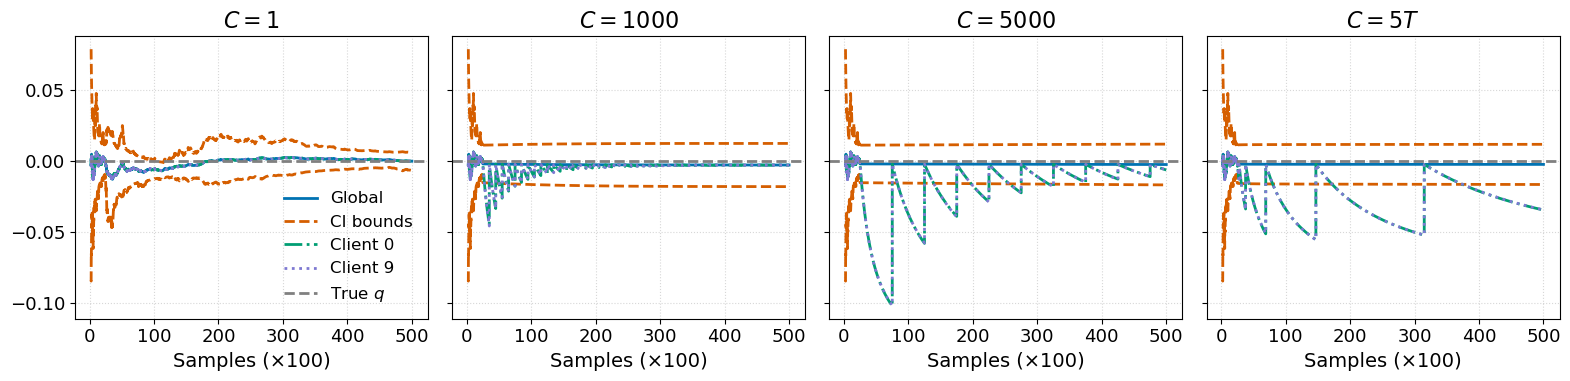

In [9]:
# y_lims = (-0.02, 0.02)
y_lims = None
fig, axes = plt.subplots(1, len(curves_all),
                         figsize=(4*len(curves_all), 4),
                         sharey=True)
for ax, curves, title in zip(axes, curves_all, titles):
    plot_single(ax, curves, title,  y_lims=y_lims,skip_frac=0.005)
axes[0].legend(frameon=False)
fig.tight_layout()
plt.savefig(f'output/trace_{gene_process}_r_{r}.pdf', dpi=250)
plt.show()

In [11]:
xs_g, gavg, lo, up, true_q, xs_c0, c0, xs_c9, c9 = curves_all[1]

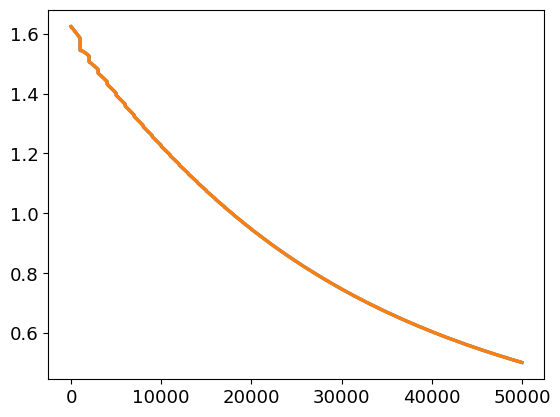

In [13]:
plt.plot(c9)
plt.plot(c0)

In [28]:
lo[10]

np.float64(0.5360121145132802)

In [27]:
up

array([ 1.50751368,  1.56101506,  1.58380287, ..., -0.22591666,
       -0.22592138, -0.22592586], shape=(7200,))

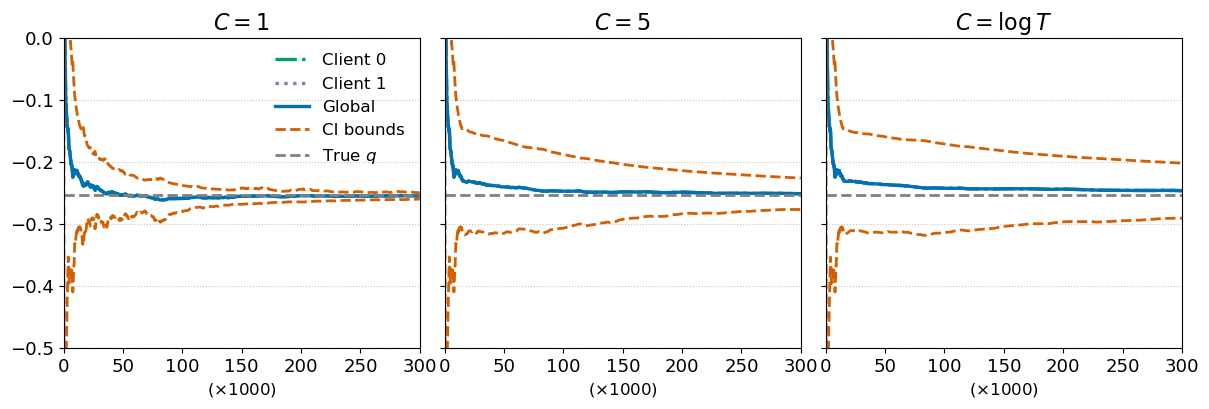

In [12]:

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5),('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)
titles = [r'$C=1$', r'$C=5$', r'$C=\log T$']   # 想写中文或别的都行

for i, (ax, curves, t) in enumerate(zip(axes, curves_all, titles)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=t,                # 关闭子图标题
               x_max=30000,
              y_lims=(-0.5,0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.07)   # ② 调整列间距；数值越小越紧
plt.savefig(f'output/trace_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [7]:
## 
tau = 0.3
gene_process = 'homo'
r = 0.9
rs = [r]*10
configs = [('cons', 1)]
N       = 20_000
seed    = 1

In [ ]:
configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1


# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.8,-0.2))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [24]:
## 
tau = 0.8
gene_process = 'homo'
r = 0.9
rs = [r]*10
configs = [('cons', 1)]
N       = 20_000
seed    = 2

In [25]:
configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=20000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

In [26]:
configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

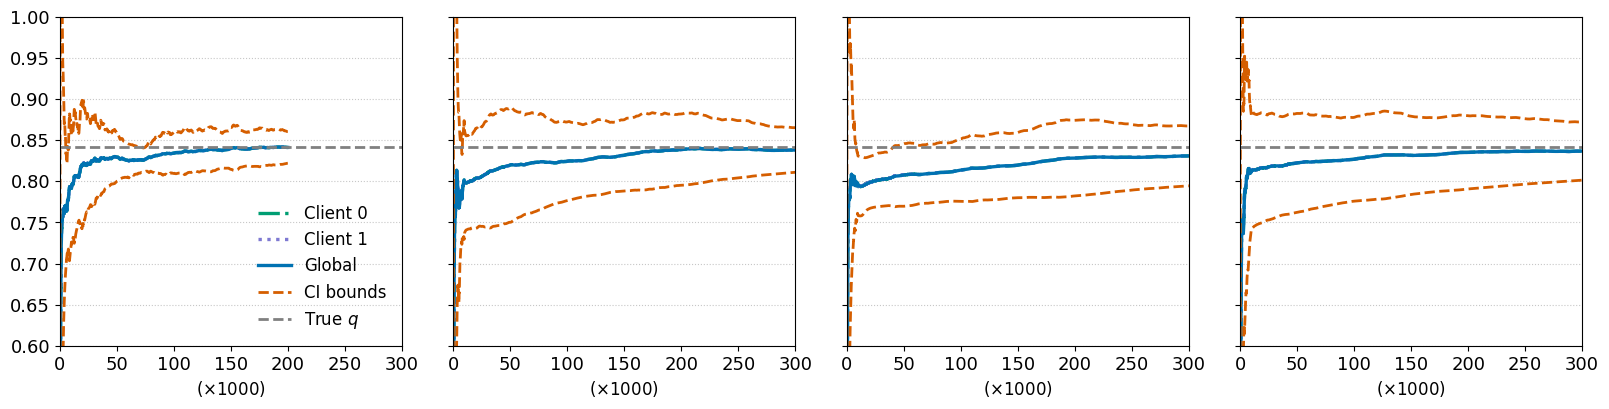

In [27]:
# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(0.6,1.0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_{r}.pdf',dpi=250)
plt.show()

In [ ]:
## 
tau = 0.5
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.15,0.15))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()

In [ ]:
## 
tau = 0.3
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000, y_lims=(-0.8,-0.2))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()

In [93]:
## 
tau = 0.8
gene_process = 'homo'
rs = np.linspace(0.25, 0.9, 10).tolist()
configs = [('cons', 1)]
N       = 20_000
# seed    = 3
seed    = 10

configs = [('cons', 1)]
curves_1 = [
    get_curves(typ, econ, N=30000, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

configs = [('cons', 5), ('cons', 10), ('log', 5)]
curves_all_1 = [
    get_curves(typ, econ, N=N, base_seed=seed,
               n_clients=10,tau=tau,
               gene_process=gene_process, rs=rs)
    for typ, econ in configs]

curves_all = curves_1 + curves_all_1

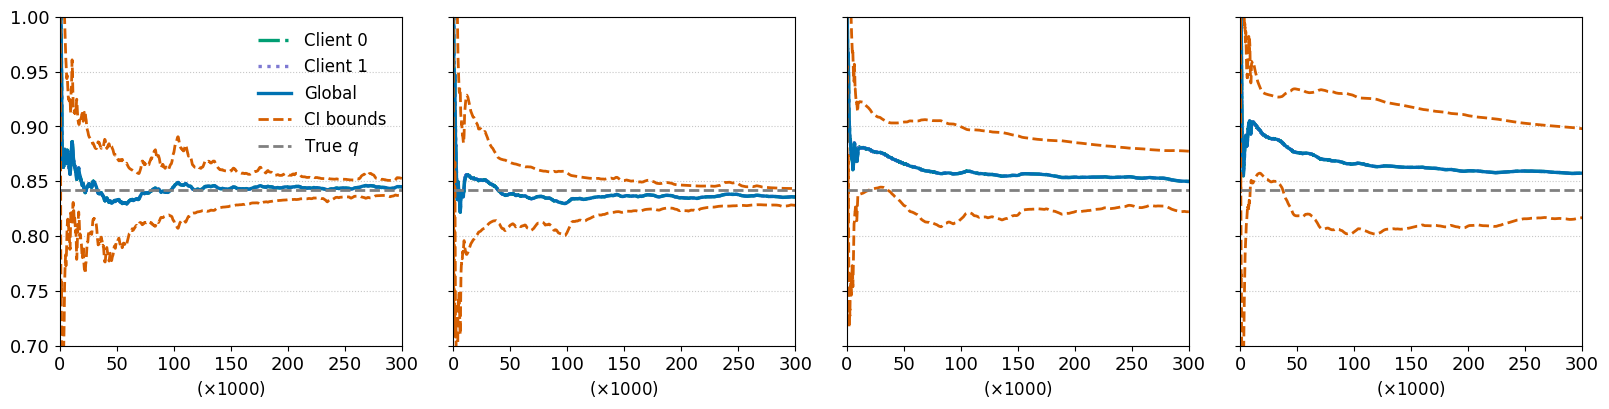

In [96]:
# ── 绘图阶段 ────────────────────────────────────────────────
configs = [('cons', 1),('cons', 5), ('cons', 10), ('log', 5)]
fig, axes = plt.subplots(1, len(configs), figsize=(4*len(configs), 4),
                         sharey=True)

for i, (ax, curves) in enumerate(zip(axes, curves_all)):
    plot_panel(ax, *curves,
               add_ylabel=False,          # 关闭 y 轴标题
               add_legend=(i == 0),       # 只在第一张放图例
               title=None,                # 关闭子图标题
               x_max=30000,y_lims=(0.7,1.0))      # 固定横轴上限

    # 去掉 x 轴标签
    ax.set_xlabel(r'$(\times 1000)$', fontsize=12)
    # ax.set_xlabel('')                     # 若不想留空白，可注释掉这行
    # 去掉 y 轴标签（已经通过 add_ylabel=False 实现）

# 可选：如果想让最外层整体去掉两侧多余空白
fig.tight_layout(pad=0.3)          # 图与图框之间留 0.3 英寸
fig.subplots_adjust(wspace=0.15)   # ② 调整列间距；数值越小越紧
plt.savefig(f'trace_tau_{tau}_{gene_process}_r_hete.pdf',dpi=250)
plt.show()